<a href="https://colab.research.google.com/github/danielarruda1000/house_sales_prediction/blob/main/house_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.

It's a great dataset for evaluating simple regression models.

## Imports

In [44]:
!pip install geopandas
!pip install shapely
!pip install catboost
!pip install shap

     |████████████████████████████████| 564 kB 8.3 MB/s 


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shap

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.linear_model import LinearRegression

from sklearn.metrics import (mean_absolute_percentage_error,
                             r2_score, mean_absolute_error,
                             mean_squared_error)


import warnings
warnings.filterwarnings("ignore")

In [3]:
pd. set_option('display.max_columns', 500)

## Loading Data

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd MyDrive/
%cd MIT DS
%cd Study\ case\ 3

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive
/gdrive/MyDrive/MIT DS
/gdrive/MyDrive/MIT DS/Study case 3


In [5]:
df = pd.read_csv('kc_house_data.csv')

## Data Analysis

In [6]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [9]:
# Casting some columns
df['bedrooms'] = df['bedrooms'].astype(int)
df['floors'] = df['floors'].astype(int)
df['date'] = pd.to_datetime(df['date'])

In [10]:
print('Same house may been sold more than once in 1 year')
df['id'].nunique() == df['id'].count()

Same house may been sold more than once in 1 year


False

In [11]:
# Considering only the last sale price for each house
df = df.sort_values('date').drop_duplicates(subset=['id'], keep='last')

### Plotting location

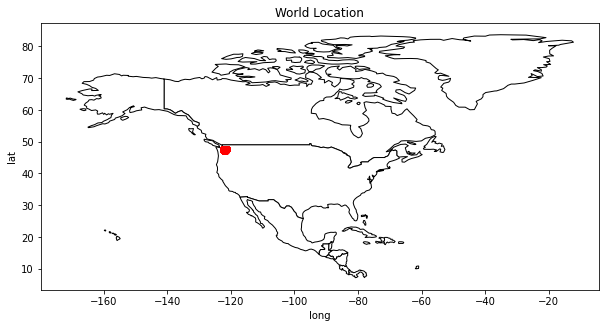

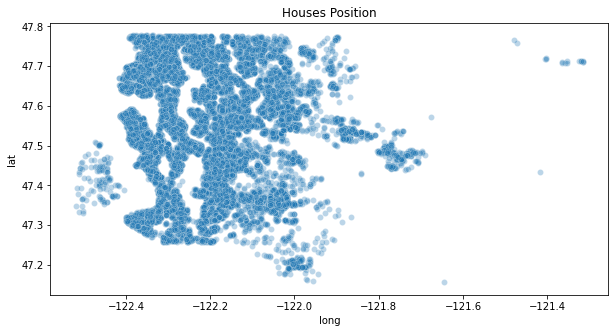

In [12]:
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black', figsize=(10,5))

gdf.plot(ax=ax, color='red')
plt.title('World Location')
plt.ylabel('lat')
plt.xlabel('long')
plt.show()


plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='long', y='lat', alpha=0.3)
plt.title('Houses Position')
plt.show()

df = df.drop(columns=['geometry'])

### Univarite Analysis

In [13]:
def plot_feature_distribution(col):
  f, (ax_box, ax_dist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

  sns.boxplot(df[col], ax=ax_box)
  sns.distplot(df[col], ax=ax_dist)
  ax_box.set(xlabel=col)
  plt.show()
  print()

In [14]:
len(df.drop(columns=['id']).select_dtypes(include=['int', 'float']).columns)

19

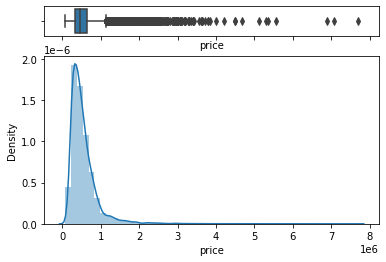

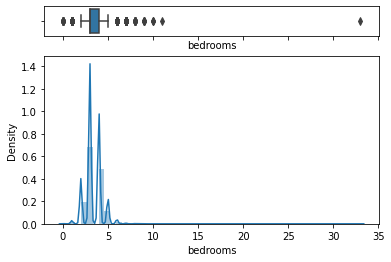

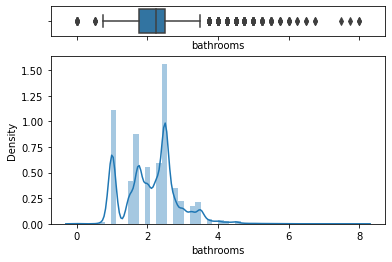

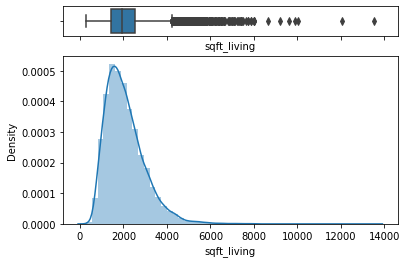

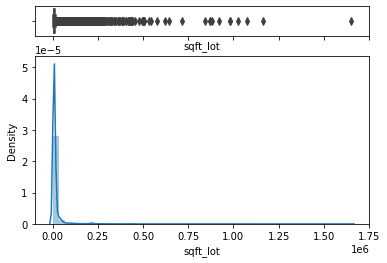

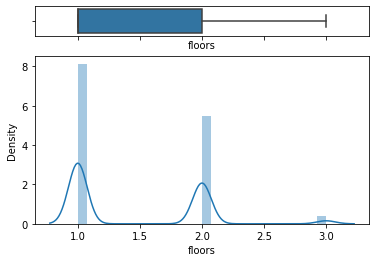

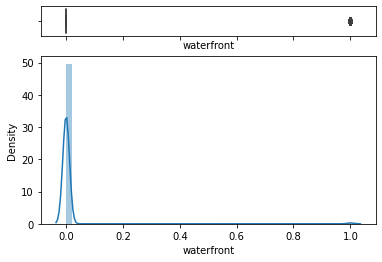

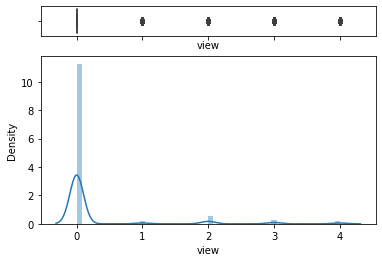

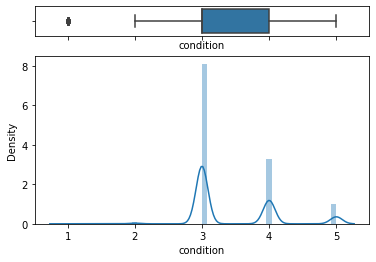

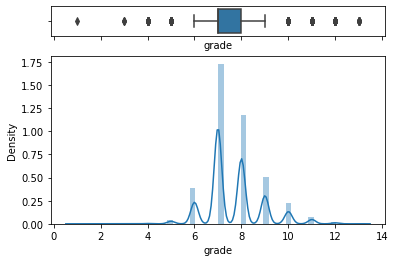

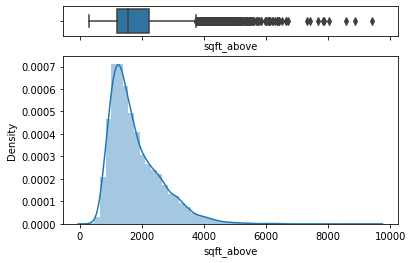

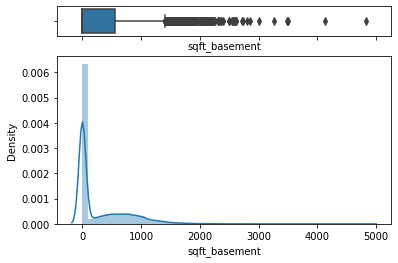

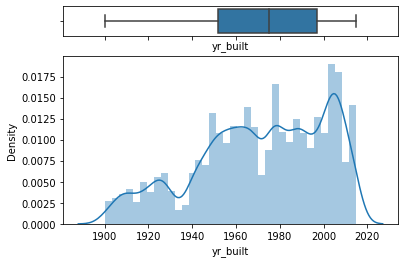

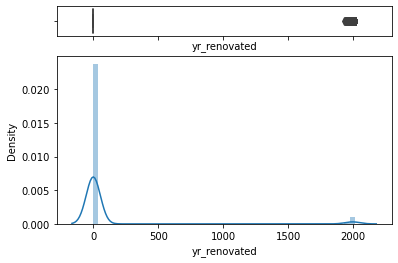

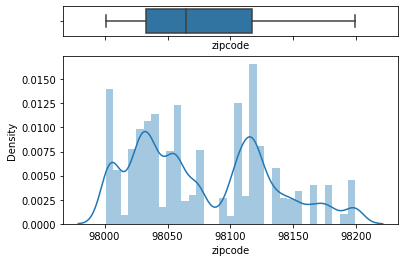

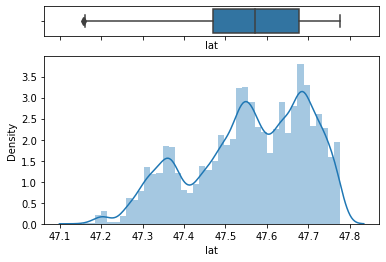

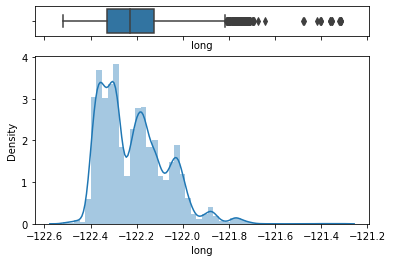

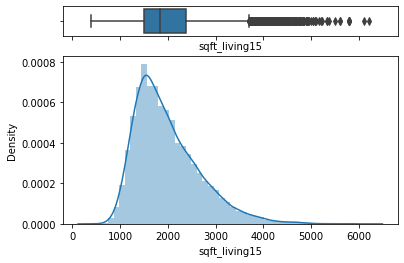

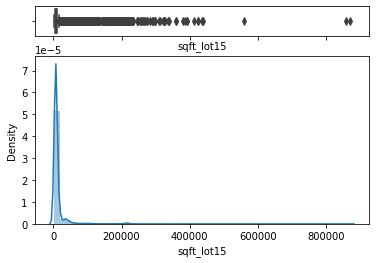

In [15]:
for col in df.drop(columns=['id']).select_dtypes(include=['int', 'float']).columns:
  plot_feature_distribution(col)

### Bivariate Analysis

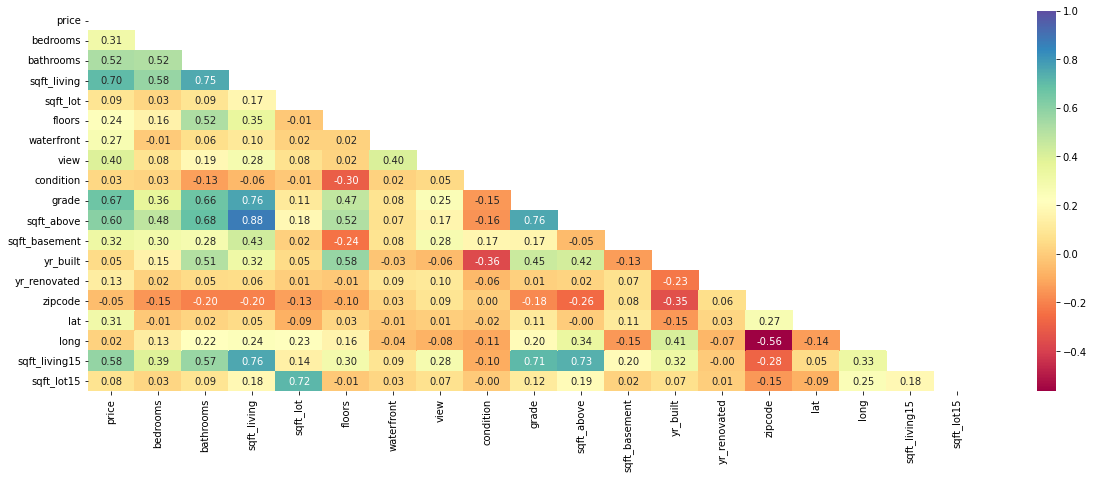

In [16]:
## Correlation Matrix
plt.figure(figsize=(20,7))

corr = df.drop(columns=['id']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask,annot=True, vmax=1, fmt='.2f',cmap='Spectral')
plt.show()

### Feature engineering

In [17]:
df['waterfront'].value_counts(normalize=True) 

0    0.992396
1    0.007604
Name: waterfront, dtype: float64

In [18]:
df['yr_renovated'].value_counts(normalize=True)

0       0.957548
2014    0.004245
2013    0.001726
2003    0.001679
2000    0.001633
          ...   
1944    0.000047
1959    0.000047
1934    0.000047
1951    0.000047
1954    0.000047
Name: yr_renovated, Length: 70, dtype: float64

* Less than 1% has waterfront. Important feature? Only the model can answer
* 95% houses doesn't renovated. Importante feature? Only the model can answer

In [19]:
df['age'] = datetime.datetime.today().year - df['yr_built']

In [20]:
df = df.drop(columns=['yr_built', 'date'])

In [21]:
df['price'].describe()

count    2.143600e+04
mean     5.416500e+05
std      3.673149e+05
min      7.500000e+04
25%      3.248660e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [22]:
# Removing price outilers
df = df[df['price']<= df['price'].quantile(0.75)]

In [23]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
16768,5561000190,437500.0,3,2.25,1970,35100,2,0,0,4,9,1970,0,0,98027,47.4635,-121.991,2340,35100,45
20602,7853361370,555000.0,4,2.50,3310,6500,2,0,0,3,8,3310,0,0,98065,47.5150,-121.870,2380,5000,10
11577,5056500260,440000.0,4,2.25,2160,8119,1,0,0,3,8,1080,1080,0,98006,47.5443,-122.177,1850,9000,56
20559,3438501320,295000.0,2,2.50,1630,1368,2,0,0,3,7,1280,350,0,98106,47.5489,-122.363,1590,2306,13
18690,1737320120,470000.0,5,2.50,2210,9655,1,0,0,3,8,1460,750,0,98011,47.7698,-122.222,2080,8633,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,6752600320,360000.0,4,2.50,2020,7289,2,0,0,3,7,2020,0,0,98031,47.4010,-122.171,2090,7259,28
7898,1422700040,183000.0,3,1.00,1170,7320,1,0,0,3,7,1170,0,0,98188,47.4685,-122.282,2040,7320,60
928,8730000270,359000.0,2,2.75,1370,1140,2,0,0,3,8,1080,290,0,98133,47.7052,-122.343,1370,1090,13
5637,7923600250,450000.0,5,2.00,1870,7344,1,0,0,3,7,1870,0,0,98007,47.5951,-122.144,1870,7650,62


## Testing models

In [24]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
lat              0.486169
grade            0.473545
sqft_living      0.440170
sqft_living15    0.398460
bathrooms        0.347626
sqft_above       0.338632
sqft_basement    0.212636
bedrooms         0.202516
floors           0.195096
view             0.123094
sqft_lot         0.069776
age              0.066890
sqft_lot15       0.065335
long             0.053764
id               0.035155
waterfront       0.029822
yr_renovated     0.025398
zipcode          0.021857
condition        0.006434
Name: price, dtype: float64

In [25]:
# Selecting features with abs corr with price more than 10%
reduced_features = ['lat', 'grade', 'sqft_living', 'sqft_living15', 'bathrooms', 'sqft_above', 'sqft_basement', 'bedrooms', 'floors', 'view']

In [26]:
def performance(y_true, y_pred):
  
  mape = round(mean_absolute_percentage_error(y_true, y_pred),2)
  mae = round(mean_absolute_error(y_true, y_pred),2)
  rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),2)
  r2 =round(r2_score(y_true, y_pred),2)

  print(f'MAE: {mae}\nMAPE: {mape}\nRMSE: {rmse}\nR2: {r2}')

In [27]:
def cros_val_performance(model, X, y):

  mape_scores = abs(round(np.mean(cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_percentage_error')),2))
  mae_scores = abs(round(np.mean(cross_val_score(reg, X, y, cv=10, scoring='neg_mean_absolute_error')),2))
  r2_scores = abs(round(np.mean(cross_val_score(reg, X, y, cv=10)),2))

  print(f'\nCrosValidation\nMAPE: {mape_scores}\nMAE: {mae_scores}\nR2: {r2_scores}')

In [37]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Linear Regression

In [28]:
X = df[reduced_features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

In [29]:
print('Train performance')
y_train_pred = reg.predict(X_train)

performance(y_train, y_train_pred)


print('\nTest performance')
y_test_pred = reg.predict(X_test)

performance(y_test, y_test_pred)
cros_val_performance(reg, X, y)

Train performance
MAE: 65802.57
MAPE: 0.18
RMSE: 83421.54
R2: 0.56

Test performance
MAE: 66547.32
MAPE: 0.18
RMSE: 84065.57
R2: 0.56

CrosValidation
MAPE: 0.18
MAE: 66146.25
R2: 0.56


#### Using all features

In [30]:
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression().fit(X_train, y_train)

print('Train performance')
y_train_pred = reg.predict(X_train)

performance(y_train, y_train_pred)


print('\nTest performance')
y_test_pred = reg.predict(X_test)

performance(y_test, y_test_pred)
cros_val_performance(reg, X, y)

Train performance
MAE: 62724.99
MAPE: 0.18
RMSE: 79515.84
R2: 0.6

Test performance
MAE: 63627.42
MAPE: 0.18
RMSE: 80421.86
R2: 0.6

CrosValidation
MAPE: 0.18
MAE: 63102.52
R2: 0.6


* With All features, the Linear Regression fits better, but the model errors are around $62.000,00 (18% of the true value). Lets try another model

### Decision Trees with CatBoost

In [31]:
import catboost as cb

In [32]:
X = df.drop(columns=['price', 'id'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [33]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
# Find best params for our model
grid = {'iterations': [100, 200, 500],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1]}

grid_search_result  = model.grid_search(grid, train_dataset, cv=5, verbose=False)

In [35]:
grid_search_result['params']

{'depth': 6, 'iterations': 500, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}

In [36]:
print('Train performance')
y_train_pred = model.predict(X_train)
performance(y_train, y_train_pred)

print('\nTest performance')
y_test_pred = model.predict(X_test)
performance(y_test, y_test_pred)

Train performance
MAE: 29917.86
MAPE: 0.09
RMSE: 39691.06
R2: 0.9

Test performance
MAE: 38098.01
MAPE: 0.11
RMSE: 52249.14
R2: 0.83


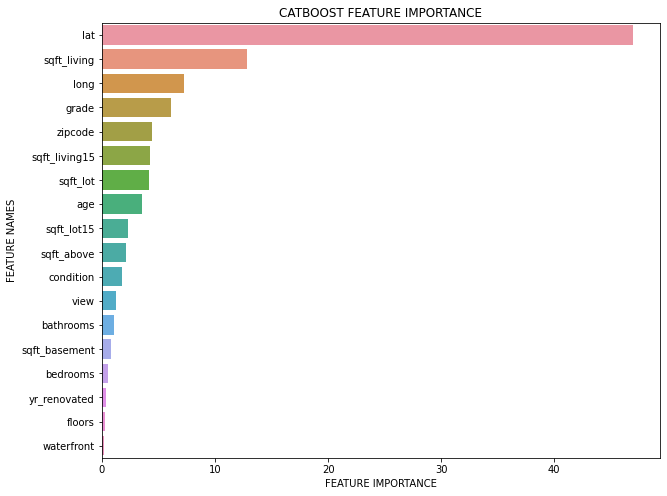

In [38]:
plot_feature_importance(model.get_feature_importance(),X_train.columns,'CATBOOST')

In [43]:
shap_values = model.get_feature_importance(test_dataset, type="ShapValues")
shap_values = shap_values[:,:-1]

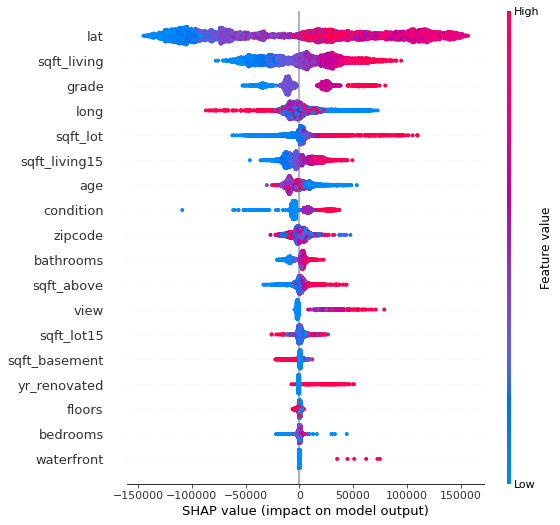

In [46]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

* The model interpret that de Latitude is most important feature for price prediction. More in noth, more expensive is the house. Second feature is square feet living, it make sense, bigger the house, more expensive is. Third is the Longitude. To sum up, we conclude that the area are decisive in the price. Similar houses has different prices depending where is located
* Catboost model performed better then a simple Linear Regression, but can be improved doing a feature engineering, but is not our case now, we just perform tow models and compare their results. Catboost have lots of features that can help us to perform a better model.